First 5 projected (x, y) coordinates:
[[1077 -714]
 [1107 -753]
 [1108 -710]
 [1087 -692]
 [ 841 -714]]


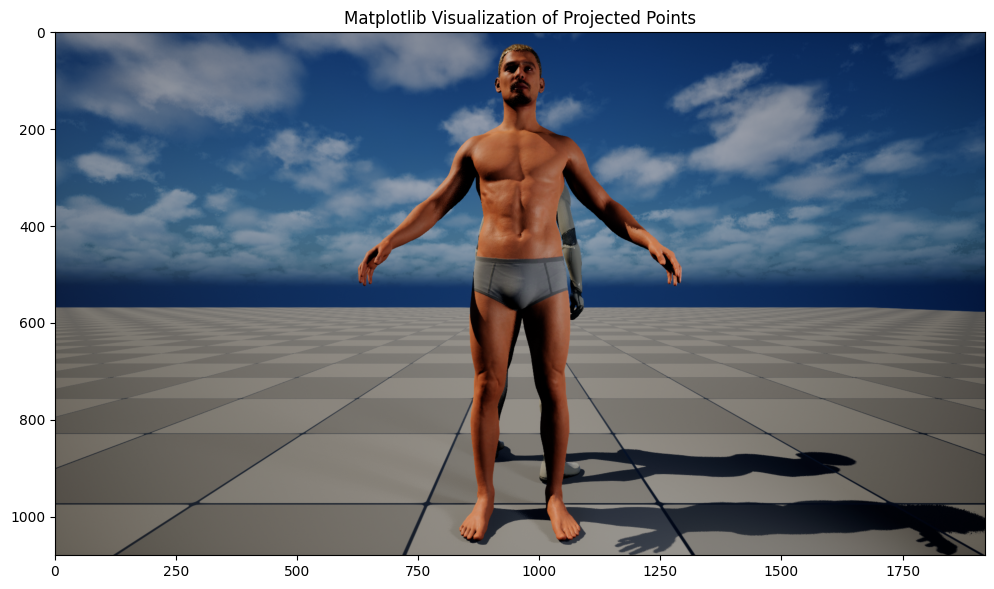

In [4]:
import numpy as np
import json
import cv2 as cv
import os
import matplotlib.pyplot as plt

# --- 1. DATA LOADING FUNCTIONS (Unchanged) ---

def create_bone_array(bone_data):
    """Parses the bone data from your JSON file."""
    just_bones = []
    for item in bone_data:
        location = item['WorldLocation']
        x, y, z = location['X'], location['Y'], location['Z']
        just_bones.append([x, y, z])
    return np.array(just_bones)

def load_camera_parameters(intrinsic_path, extrinsic_path):
    """Loads the camera's intrinsic and extrinsic matrices."""
    with open(intrinsic_path, 'r') as f:
        intrinsic_data = json.load(f)
    with open(extrinsic_path, 'r') as f:
        extrinsic_data = json.load(f)
        
    K = np.array(intrinsic_data['Intrinsics']['IntrinsicMatrix'])
    extrinsic_cv_4x4 = np.array(extrinsic_data['Extrinsics']['ExtrinsicMatrix_CV'])
    
    return K, extrinsic_cv_4x4

# --- 2. CORE COMPUTER VISION FUNCTIONS (Unchanged) ---

def convert_ue_points_to_cv(points_ue):
    """Converts 3D points from Unreal's coordinate system to the CV standard."""
    points_cv = np.zeros_like(points_ue)
    points_cv[:, 0] =  points_ue[:, 1]
    points_cv[:, 1] = -points_ue[:, 2]
    points_cv[:, 2] =  points_ue[:, 0]
    return points_cv

def project_points(points_3d, projection_matrix):
    """Projects 3D points to 2D pixel coordinates using the projection matrix."""
    points_3d_homo = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    points_2d_homo = (projection_matrix @ points_3d_homo.T).T
    
    w = points_2d_homo[:, 2]
    w[w == 0] = 1e-6 # Avoid division by zero
    
    points_2d = points_2d_homo[:, :2] / w[:, np.newaxis]
    return points_2d.astype(int)

# --- 3. MAIN WORKFLOW ---

if __name__ == "__main__":
    # Define file paths
    saved_path = "C:/Users/20716400/Documents/Unreal Projects/ExtractJointLocation/Saved"
    camera_name = "CineCameraActor_0"
    
    intrinsic_path = os.path.join(saved_path, "CameraData", camera_name, f"Intrinsics_{camera_name}.json")
    extrinsic_path = os.path.join(saved_path, "CameraData", camera_name, f"Extrinsics_{camera_name}.json")
    face_subset_path = os.path.join(saved_path, "FaceSubset", "BP_Carl_C_1_FaceSubset_BoneLocations.json")
    image_path = os.path.join(saved_path, "CameraFrames", "Camera1_Frame.png")

    # --- Load Data ---
    intrinsic_matrix, extrinsic_matrix_cv = load_camera_parameters(intrinsic_path, extrinsic_path)
    with open(face_subset_path, 'r') as f:
        face_keypoints = json.load(f)['Keypoints']
    face_bones_ue = create_bone_array(face_keypoints)
    
    # Load image with OpenCV, but convert from BGR to RGB for Matplotlib
    image_bgr = cv.imread(image_path)
    image_rgb = cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
    
    # --- Perform Projection ---
    extrinsic_3x4 = extrinsic_matrix_cv.T[:3, :]
    projection_matrix = intrinsic_matrix @ extrinsic_3x4
    face_bones_cv = convert_ue_points_to_cv(face_bones_ue)
    projected_2d_points = project_points(face_bones_cv, projection_matrix)

    # --- Step 4: Visualize with Matplotlib ---
    
    # Print the first 5 projected coordinates to see their values
    print("First 5 projected (x, y) coordinates:")
    print(projected_2d_points[:5])
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    
    # Display the image
    ax.imshow(image_rgb)
    
    # Plot the projected points as a scatter plot
    # We unpack the array into x and y columns for the scatter function
    ax.scatter(projected_2d_points[:, 0], projected_2d_points[:, 1], c='red', s=10) # s is marker size
    
    # Set the plot limits to match the image dimensions
    height, width, _ = image_rgb.shape
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0) # Invert y-axis to match image coordinates (0,0 is top-left)
    
    ax.set_title("Matplotlib Visualization of Projected Points")
    plt.show()